# APS Failure Prediction with Tree-Based Methods

This project implements machine learning models to predict Air Pressure System (APS) failures in Scania trucks using tree-based methods including Random Forest and XGBoost. The project addresses class imbalance using techniques like SMOTE and balanced class weights.

## Overview

The Air Pressure System (APS) is critical for truck operations, generating pressurized air for functions like braking and gear changes. This project builds predictive models to identify component failures before they cause breakdowns.

**Key Features:**
- Handles highly imbalanced dataset (1.67% positive class)
- Implements Random Forest and XGBoost classifiers
- Uses SMOTE for synthetic oversampling
- Feature selection using coefficient of variation
- Comprehensive model evaluation with ROC curves and confusion matrices

## 1. Tree-Based Methods for APS Failure Prediction

### Import Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

### (a) Load the APS Failure Data

In [2]:
train_df = pd.read_csv("../data/aps_failure_training_set.csv", na_values='na', skiprows=20)
test_df = pd.read_csv("../data/aps_failure_test_set.csv", na_values='na', skiprows=20)

### (b) Data Preparation

#### (i) Missing Value Imputation Techniques

1. **Mean/Median/Mode Imputation**: Replace missing values with the mean (for continuous variables), median (robust to outliers), or mode (for categorical variables) of the feature. This can underestimate variance.

2. **K-Nearest Neighbors (KNN) Imputation**: Use the values from k most similar observations to impute missing values. Computationally expensive.

3. **Multiple Imputation**: Create multiple imputed datasets and combine results. Handles uncertainty but is complex.

4. **Forward/Backward Fill**: For time series data, fill with previous or next values.

5. **Regression Imputation**: Use other features to predict missing values via regression.

For this dataset, we'll use **Median Imputation** as it's robust to outliers and computationally efficient for large datasets.

In [3]:
# map class to numeric
train_df['class'] = train_df['class'].map({'neg': 0, 'pos': 1})
test_df['class'] = test_df['class'].map({'neg': 0, 'pos': 1})

X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

# median imputation
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

#### (ii) Calculate the Coefficient of Variation

In [4]:
# calculate CV
s = X_train_imputed.std()
m = X_train_imputed.mean()
cv = s / m
cv = cv.abs().fillna(0)  # handle division by zero

cv_sorted = cv.sort_values(ascending=False)

#### (iii) Plot a Correlation Matrix

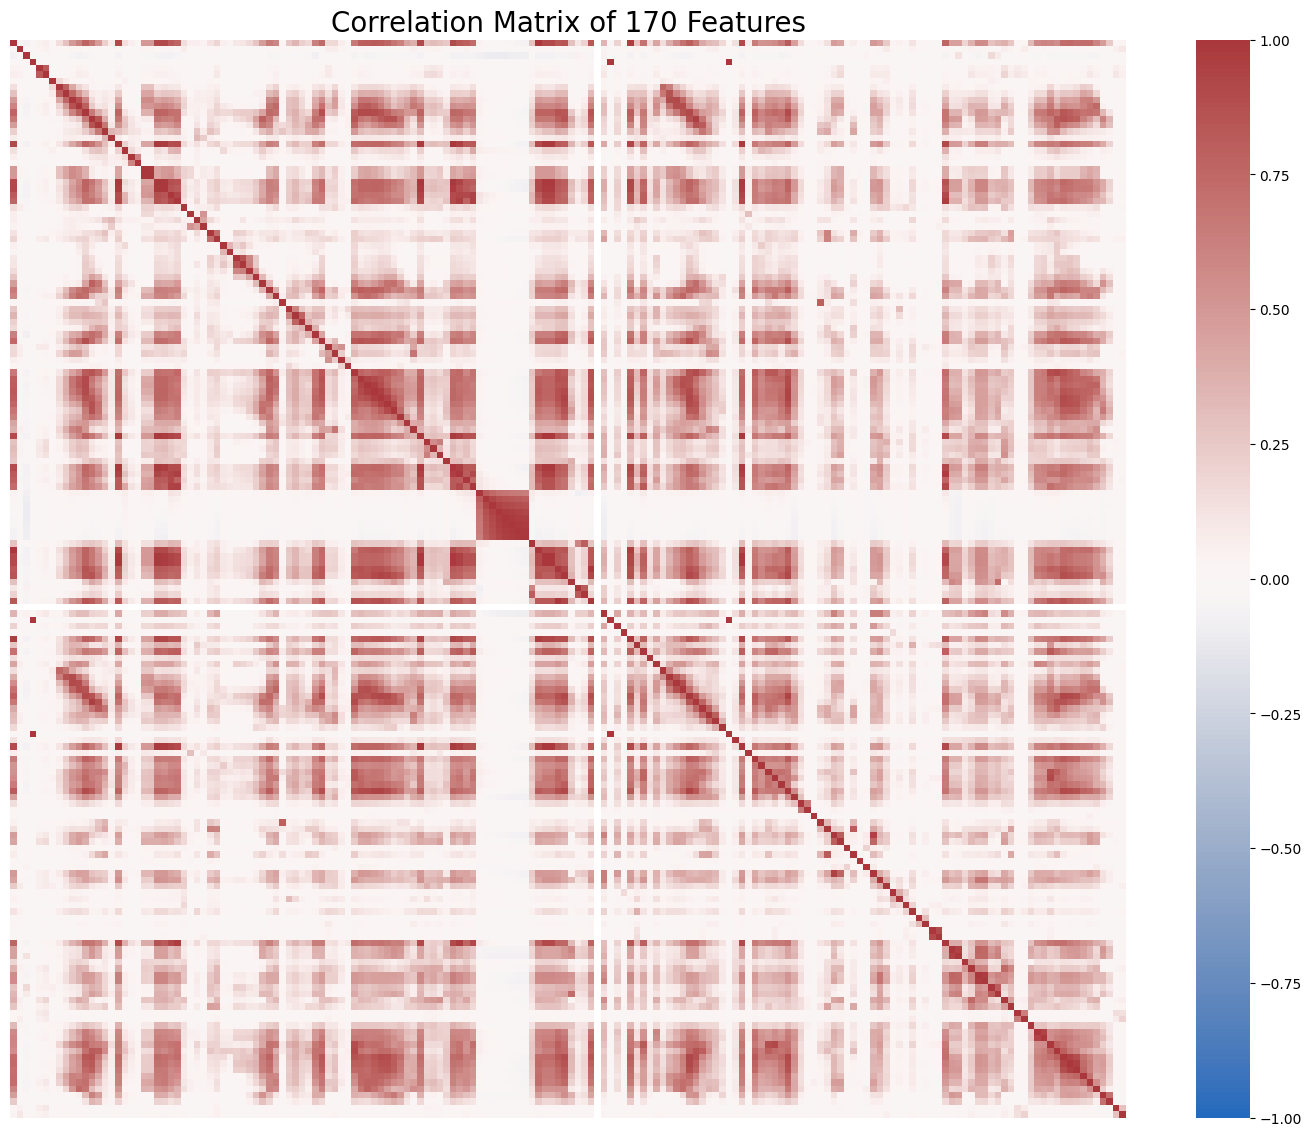

In [5]:
corr_matrix = X_train_imputed.corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap='vlag', center=0, vmin=-1, vmax=1, 
            xticklabels=False, yticklabels=False)
plt.title('Correlation Matrix of 170 Features', fontsize=20)
plt.show()

#### (iv) Make Scatter Plots and Box Plots

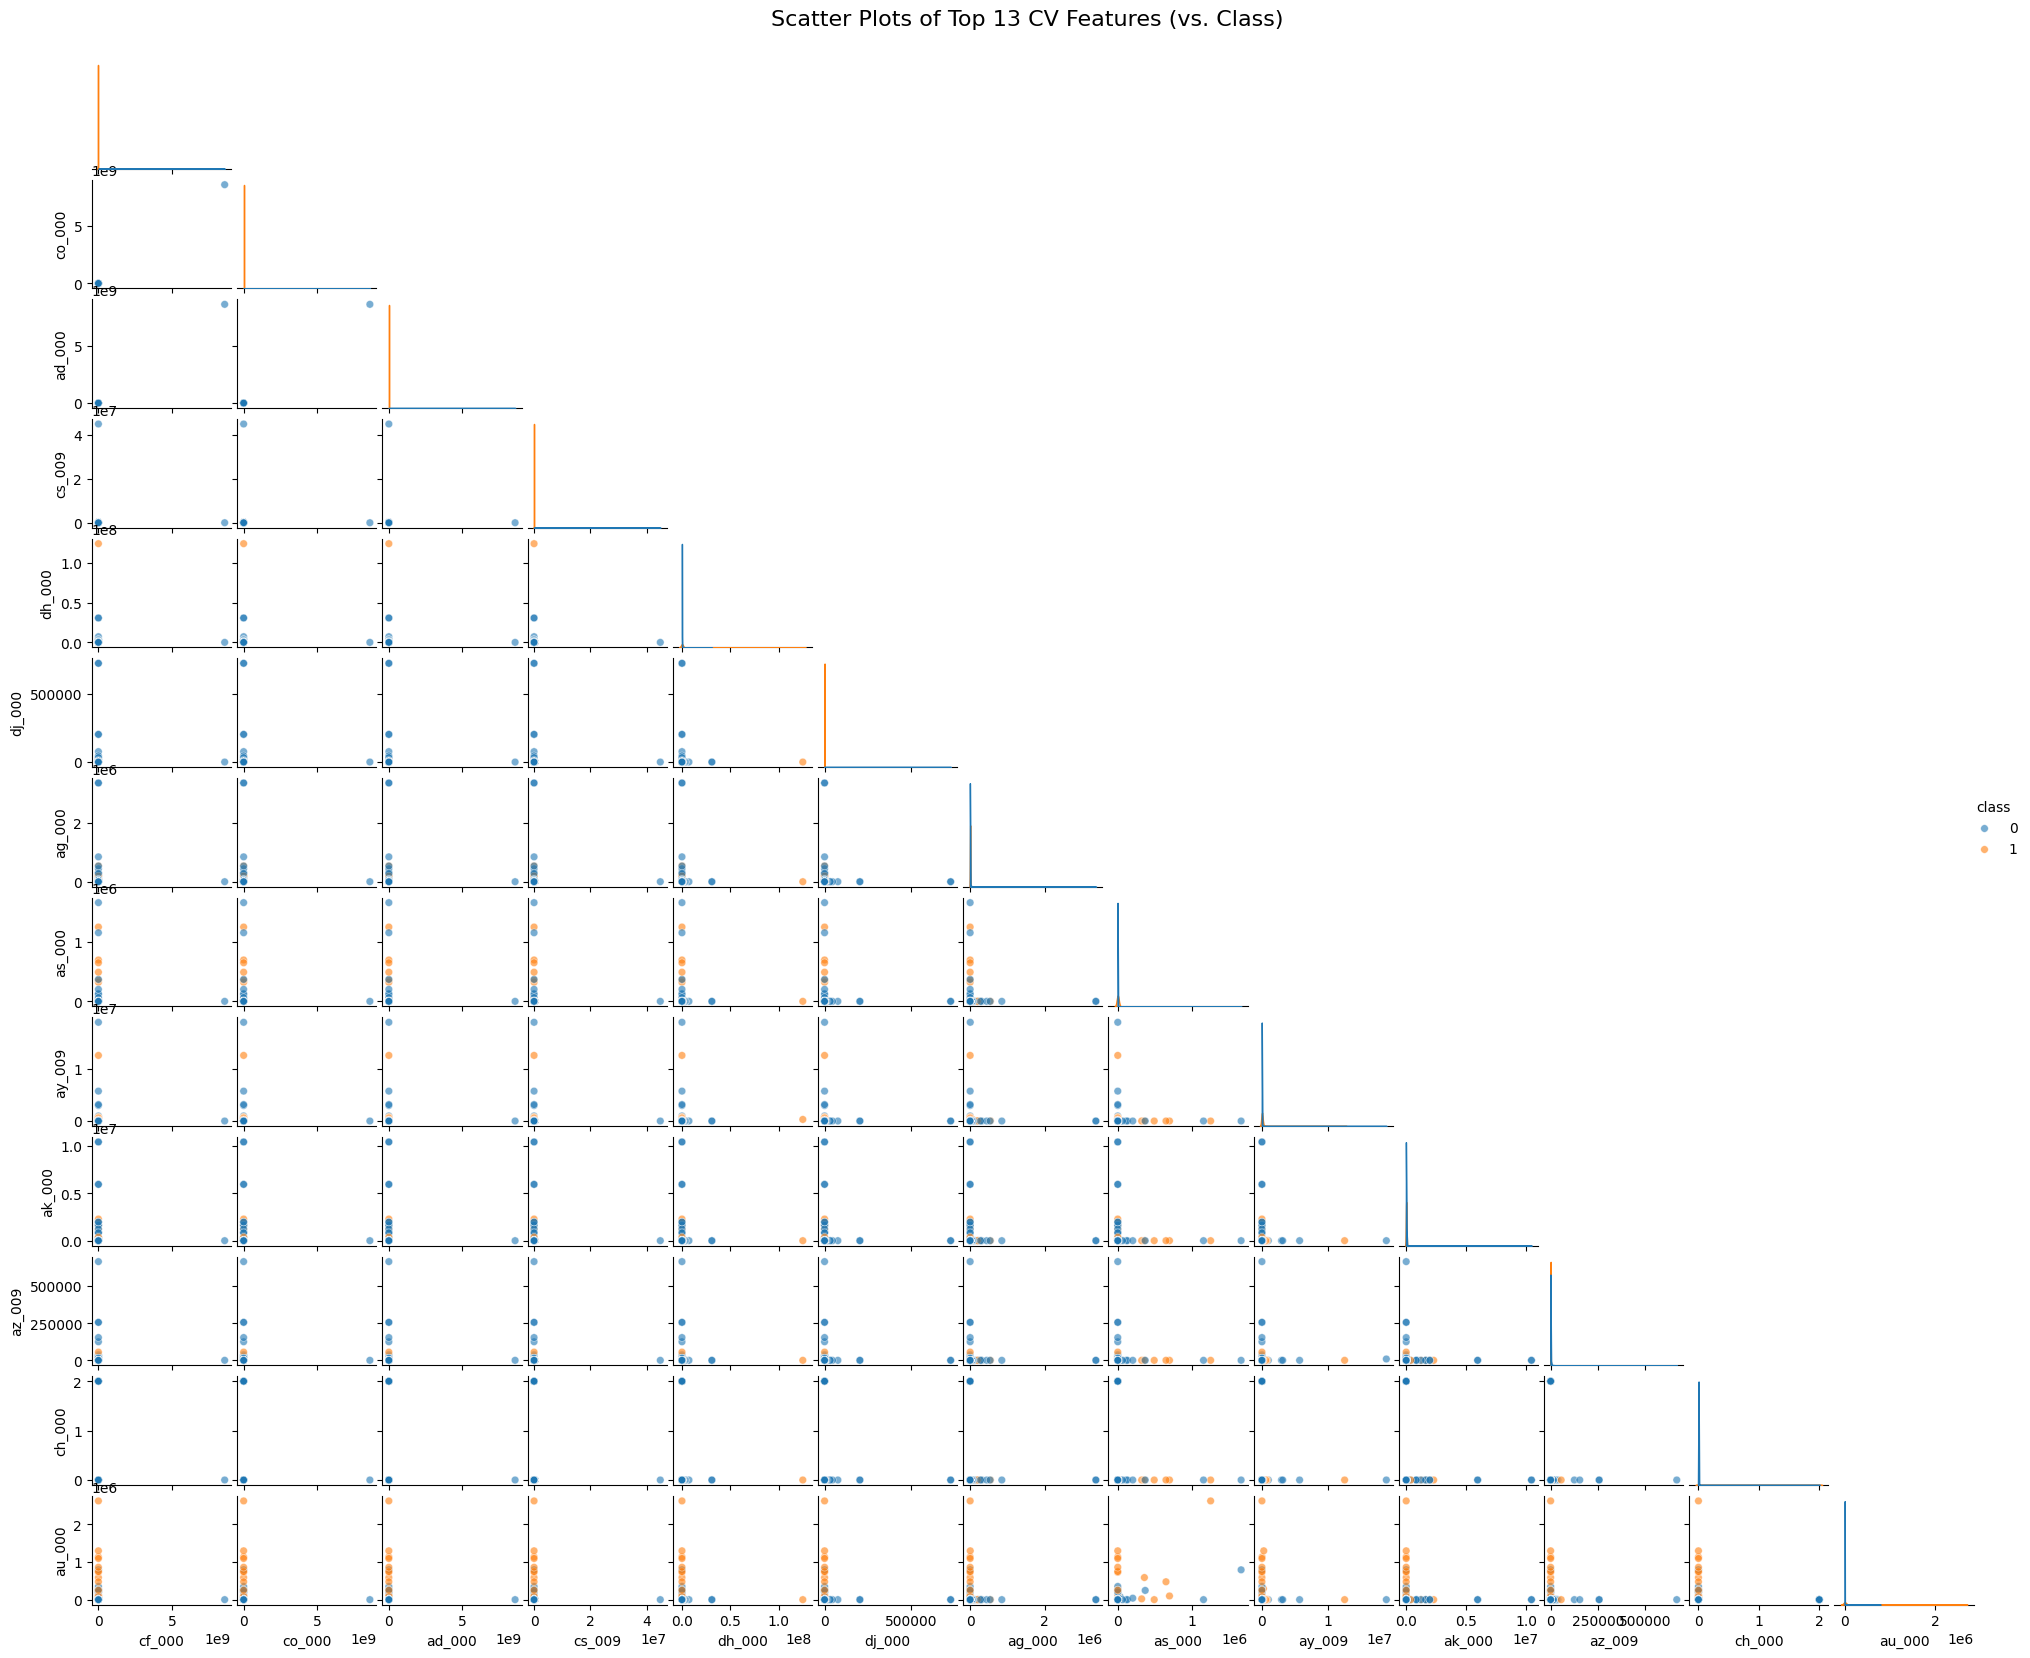

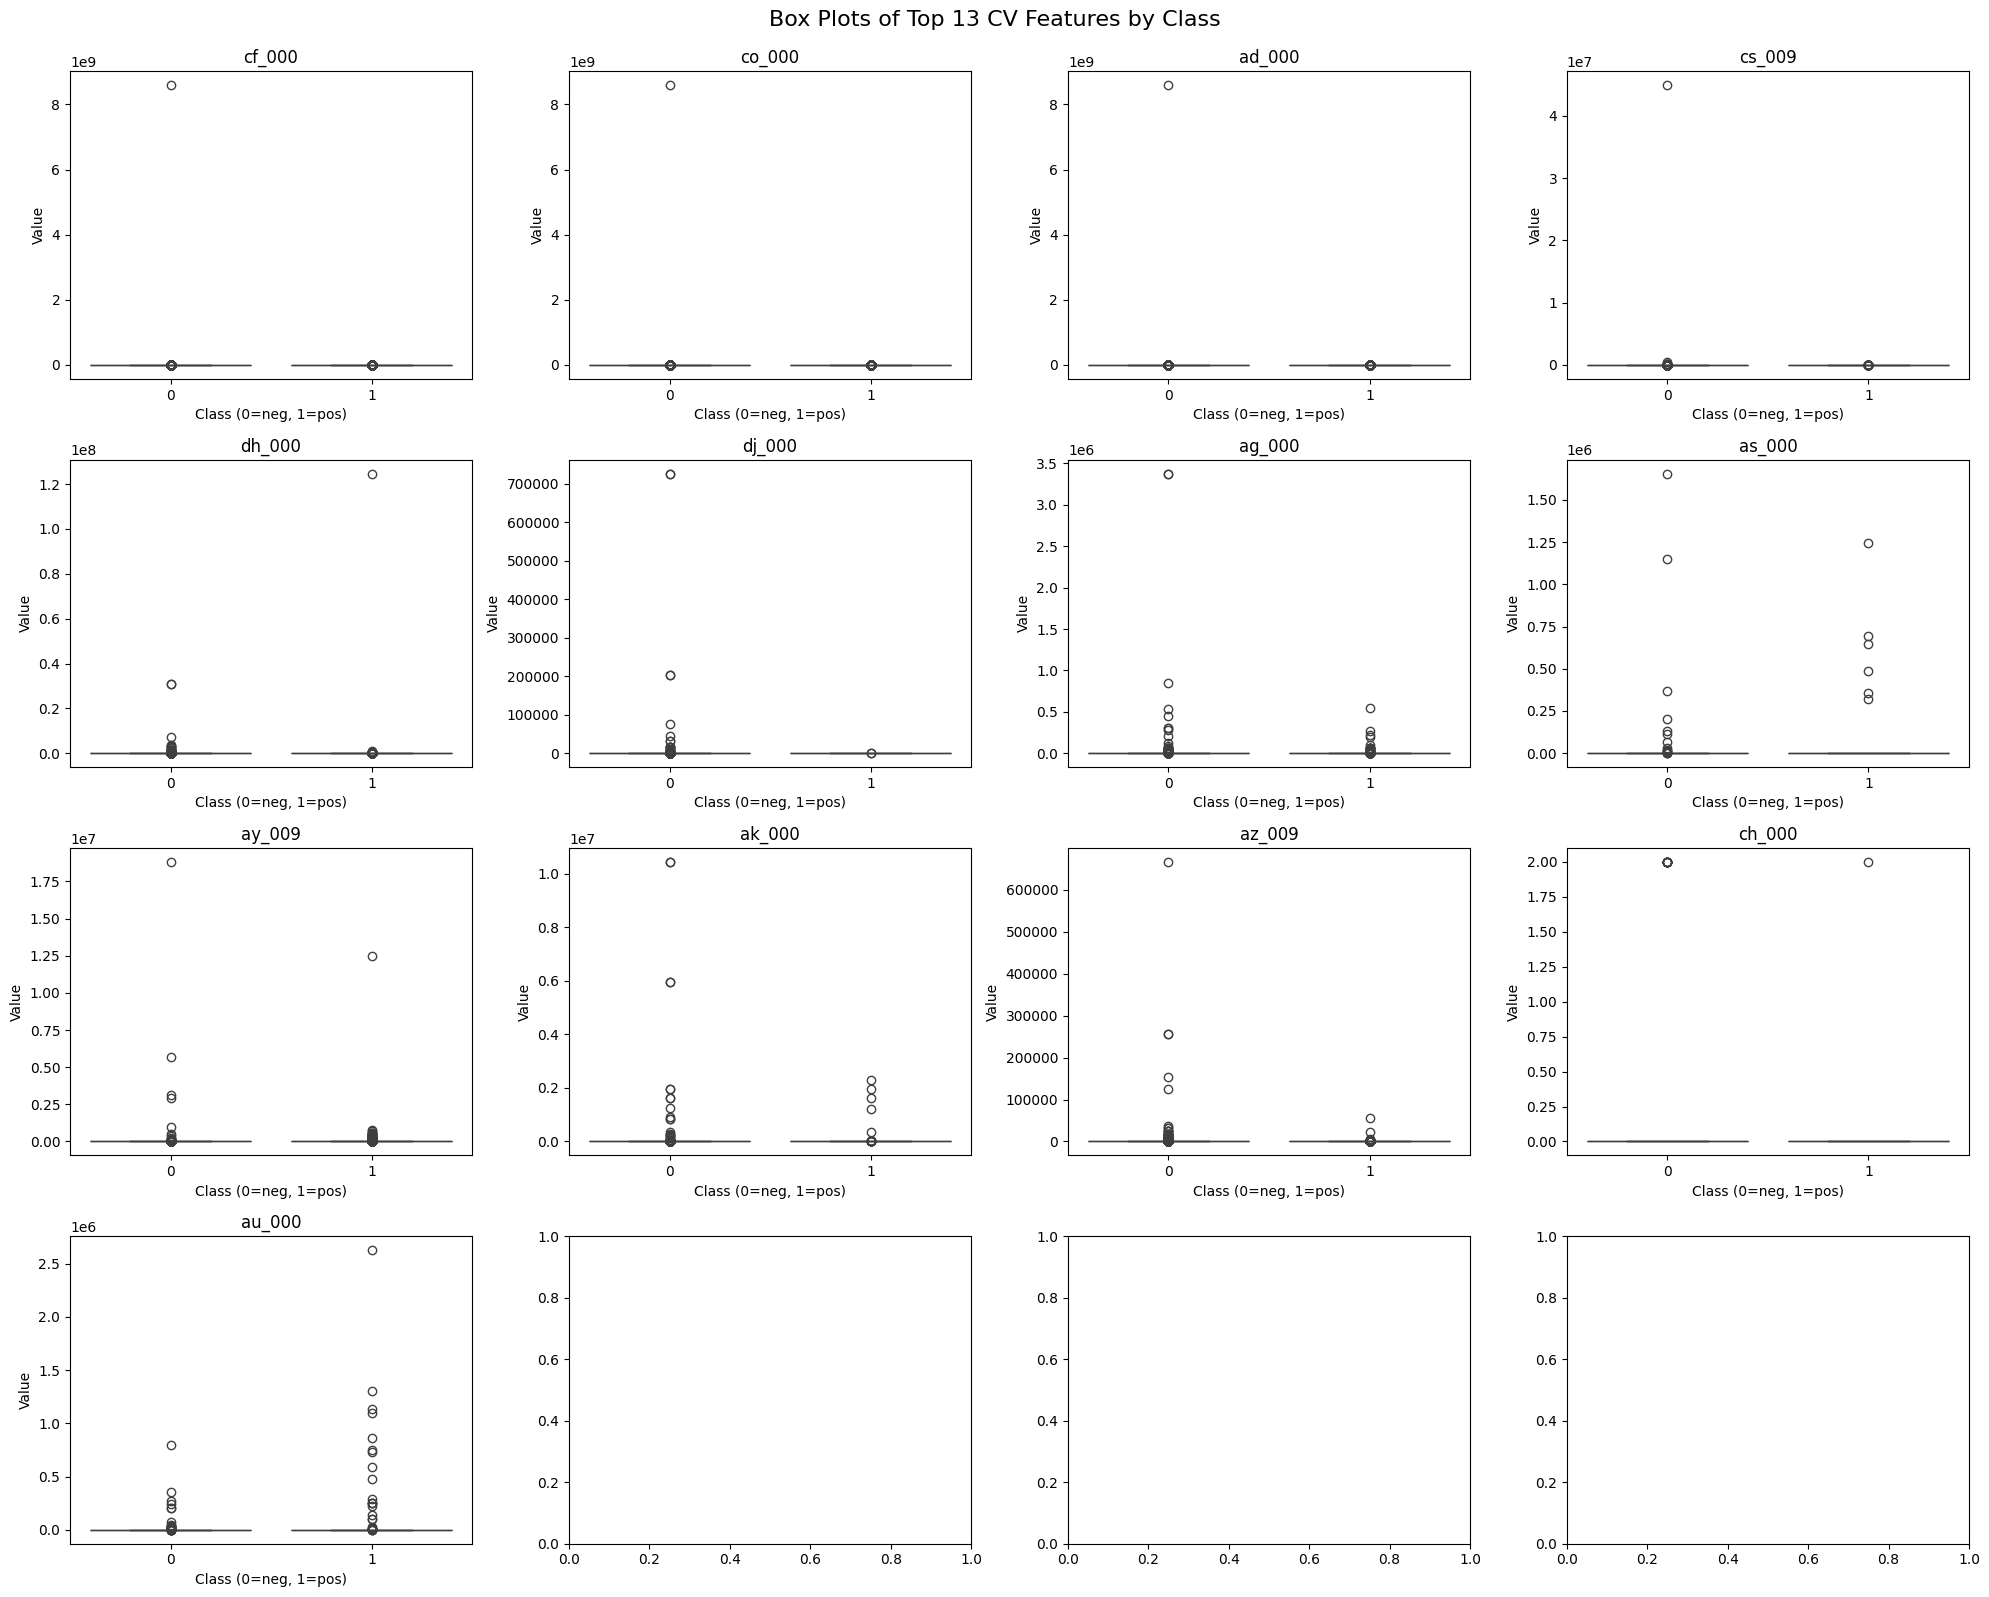

In [6]:
# pick k = floor(sqrt(170)) features
k = int(np.floor(np.sqrt(170)))
top_k_features = cv_sorted.head(k).index.tolist()

plot_df = pd.concat([X_train_imputed[top_k_features], y_train], axis=1)

# scatter plots
pairplot_obj = sns.pairplot(plot_df, hue='class', plot_kws={'alpha': 0.6, 's': 30}, corner=True, height=3)
pairplot_obj.fig.set_size_inches(20, 16)
pairplot_obj.fig.suptitle(f'Scatter Plots of Top {k} CV Features (vs. Class)', y=1.02, fontsize=16)
plt.show()

# box plots
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()
for i, col in enumerate(top_k_features):
    sns.boxplot(x='class', y=col, data=plot_df, ax=axes[i])
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('Class (0=neg, 1=pos)')
    axes[i].set_ylabel('Value')
plt.tight_layout(rect=[0, 0, 1, 0.98])
fig.suptitle(f'Box Plots of Top {k} CV Features by Class', fontsize=16, y=0.995)
plt.show()

From the scatter plots and box plots, we can observe that many of the top CV features show visible separation between the two classes (negative=0 in blue, positive=1 in orange), but with significant overlap, suggesting these features have some discriminative ability. 

The box plots reveal that for several features, the distribution of values differs between classes (e.g., different medians, IQRs, or ranges), but the overlap indicates that no single feature perfectly separates the classes. 

The pair plots show relationships between features, and some feature pairs show distinct patterns for each class, suggesting that combinations of features may be more powerful than individual features alone. However, true discriminative power requires considering all features together, which is why we use ensemble methods like Random Forest and XGBoost that can capture complex interactions.

#### (v) Class Imbalance Analysis

In [7]:
class_counts = y_train.value_counts()
print("Class Distribution:")
print(class_counts)

total_rows = len(y_train)
pos_count = class_counts.get(1, 0)
neg_count = class_counts.get(0, 0)
pos_percentage = (pos_count / total_rows) * 100

print(f"\nTotal: {total_rows}")
print(f"Negative (0): {neg_count}")
print(f"Positive (1): {pos_count}")
print(f"Percentage positive: {pos_percentage:.2f}%")

Class Distribution:
class
0    59000
1     1000
Name: count, dtype: int64

Total: 60000
Negative (0): 59000
Positive (1): 1000
Percentage positive: 1.67%


This dataset is highly imbalanced. The positive class (1) represents only 1.67% of the data, while the negative class (0) represents 98.33% of the data.

### (c) Train a Random Forest Classifier


Training:
Accuracy: 1.0000
Misclassification: 0.0000
AUC: 1.0000
Confusion Matrix:
[[59000     0]
 [    1   999]]


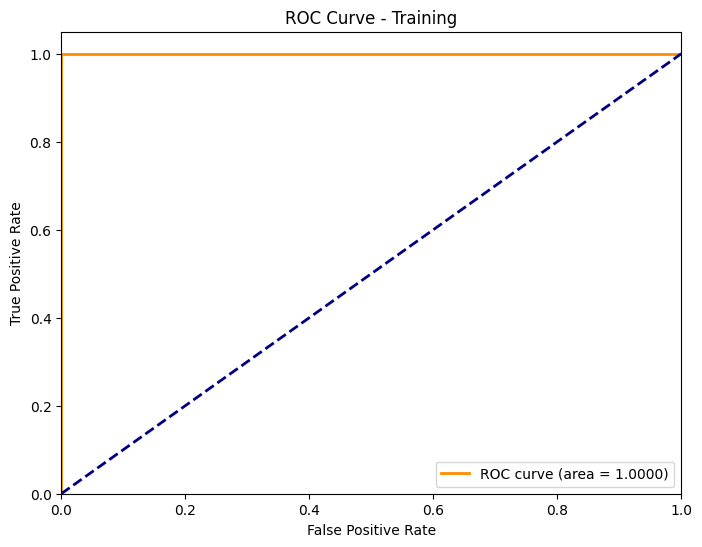


Test:
Accuracy: 0.9924
Misclassification: 0.0076
AUC: 0.9928
Confusion Matrix:
[[15610    15]
 [  106   269]]


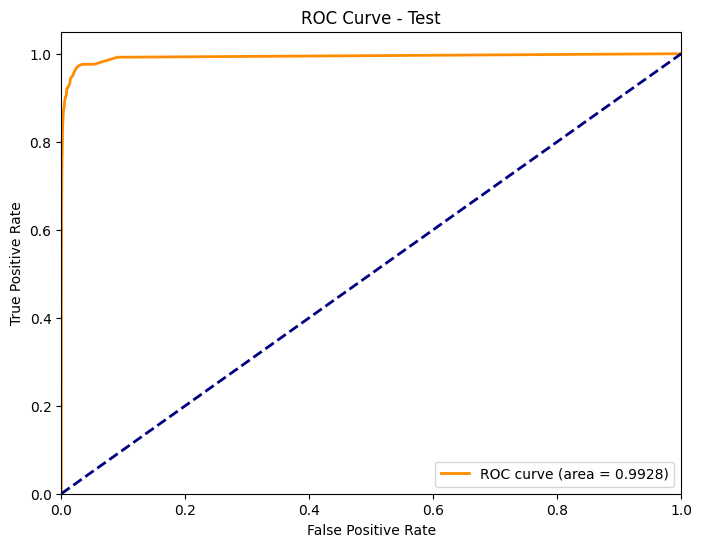


OOB Error: 0.0061
Test Error: 0.0076


In [8]:
def print_metrics(y_true, y_pred, y_prob, set_name="Test"):
    acc = accuracy_score(y_true, y_pred)
    misclassification = 1 - acc
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    print(f"\n{set_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Misclassification: {misclassification:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {set_name}')
    plt.legend(loc="lower right")
    plt.show()

# train random forest without compensation
rf_basic = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1)
rf_basic.fit(X_train_imputed, y_train)

# training set metrics
y_train_pred_rf = rf_basic.predict(X_train_imputed)
y_train_prob_rf = rf_basic.predict_proba(X_train_imputed)[:, 1]
print_metrics(y_train, y_train_pred_rf, y_train_prob_rf, set_name="Training")

# test set metrics
y_test_pred_rf = rf_basic.predict(X_test_imputed)
y_test_prob_rf = rf_basic.predict_proba(X_test_imputed)[:, 1]
print_metrics(y_test, y_test_pred_rf, y_test_prob_rf, set_name="Test")

# OOB vs test error
oob_error = 1 - rf_basic.oob_score_
test_error = 1 - accuracy_score(y_test, y_test_pred_rf)

print(f"\nOOB Error: {oob_error:.4f}")
print(f"Test Error: {test_error:.4f}")

### (d) Handling Class Imbalance in Random Forest

Common techniques for handling class imbalance in Random Forest:

1. **Weighted classes**: Assign a higher misclassification cost to the minority class. 

2. **Resampling**: Involves changing the dataset before training. 
   - **Oversampling**: Up-samples the minority class (by creating synthetic samples like SMOTE) until it is balanced with the majority class.
   - **Undersampling**: Down-samples the majority class (randomly removes data points) until it is balanced with the minority class; this is useful for very large datasets but risks discarding important information.

3. **Balanced bagging**: Ensures each bootstrap sample created for each tree is balanced, typically by oversampling the minority class and/or undersampling the majority class within that specific bag.


Training (Balanced):
Accuracy: 1.0000
Misclassification: 0.0000
AUC: 1.0000
Confusion Matrix:
[[59000     0]
 [    1   999]]


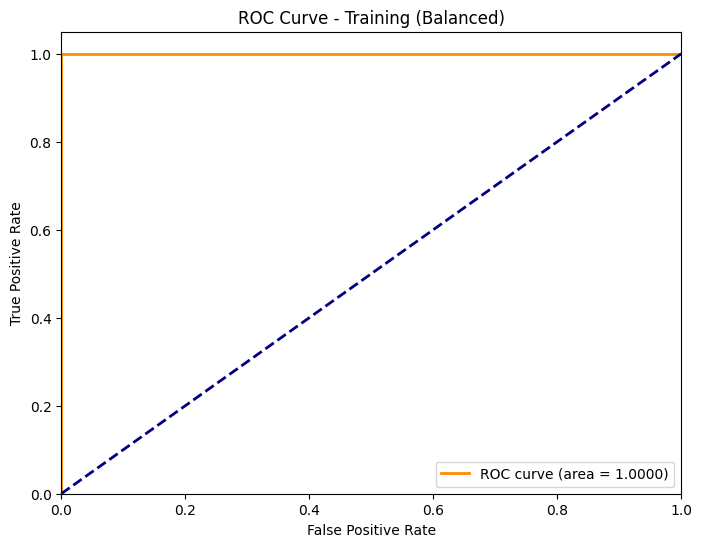


Test (Balanced):
Accuracy: 0.9891
Misclassification: 0.0109
AUC: 0.9919
Confusion Matrix:
[[15611    14]
 [  160   215]]


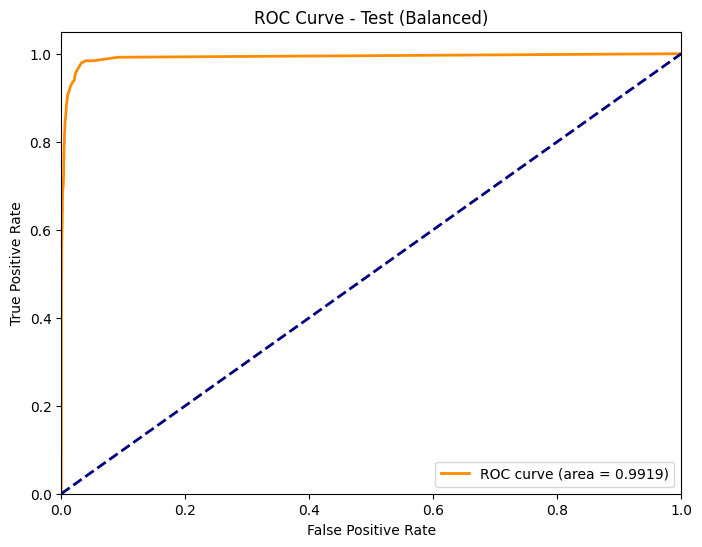


OOB Error: 0.0082
Test Error: 0.0109

Comparison:
Uncompensated - Accuracy: 0.9924, Misclassification: 0.0076, AUC: 0.9928, OOB: 0.0061
Compensated   - Accuracy: 0.9891, Misclassification: 0.0109, AUC: 0.9919, OOB: 0.0082


In [9]:
# train random forest with class_weight='balanced'
rf_balanced = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1,
                                 class_weight='balanced')
rf_balanced.fit(X_train_imputed, y_train)

# training set
y_train_pred_rf_b = rf_balanced.predict(X_train_imputed)
y_train_prob_rf_b = rf_balanced.predict_proba(X_train_imputed)[:, 1]
print_metrics(y_train, y_train_pred_rf_b, y_train_prob_rf_b, set_name="Training (Balanced)")

# test set
y_test_pred_rf_b = rf_balanced.predict(X_test_imputed)
y_test_prob_rf_b = rf_balanced.predict_proba(X_test_imputed)[:, 1]
print_metrics(y_test, y_test_pred_rf_b, y_test_prob_rf_b, set_name="Test (Balanced)")

# OOB vs test error
oob_error_b = 1 - rf_balanced.oob_score_
test_error_b = 1 - accuracy_score(y_test, y_test_pred_rf_b)

print(f"\nOOB Error: {oob_error_b:.4f}")
print(f"Test Error: {test_error_b:.4f}")

# compare with uncompensated
print(f"\nComparison:")
print(f"Uncompensated - Accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}, Misclassification: {test_error:.4f}, AUC: {roc_auc_score(y_test, y_test_prob_rf):.4f}, OOB: {oob_error:.4f}")
print(f"Compensated   - Accuracy: {accuracy_score(y_test, y_test_pred_rf_b):.4f}, Misclassification: {test_error_b:.4f}, AUC: {roc_auc_score(y_test, y_test_prob_rf_b):.4f}, OOB: {oob_error_b:.4f}")

**Balanced vs Uncompensated Random Forest**

The balanced model has slightly lower overall accuracy (98.91% vs 99.24%), but this is expected when dealing with class imbalance. The uncompensated model achieves high accuracy by correctly predicting the majority class (negative) most of the time, but may miss positive cases. 

In terms of confusion matrix analysis, the uncompensated model has 106 false negatives and 15 false positives, while the balanced model has 160 false negatives and 14 false positives. Interestingly, the balanced model actually identifies fewer true positives (215 vs 269), but has fewer false positives (14 vs 15).

The AUC is slightly lower for balanced (0.9919 vs 0.9928), but this difference is minimal as both models perform very well. By increasing the weight of the minority class, the balanced model "pays more attention" to correctly classifying positive cases, which is often the goal in imbalanced problems (detecting failures). However, this comes at the cost of overall accuracy, as the model may over-correct and misclassify some negative cases. 

If missing a positive case is costly, balanced weighting is preferred despite lower overall accuracy.

### (e) XGBoost Classifier

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Training (XGB-Unbalanced):
Accuracy: 1.0000
Misclassification: 0.0000
AUC: 1.0000
Confusion Matrix:
[[59000     0]
 [    1   999]]


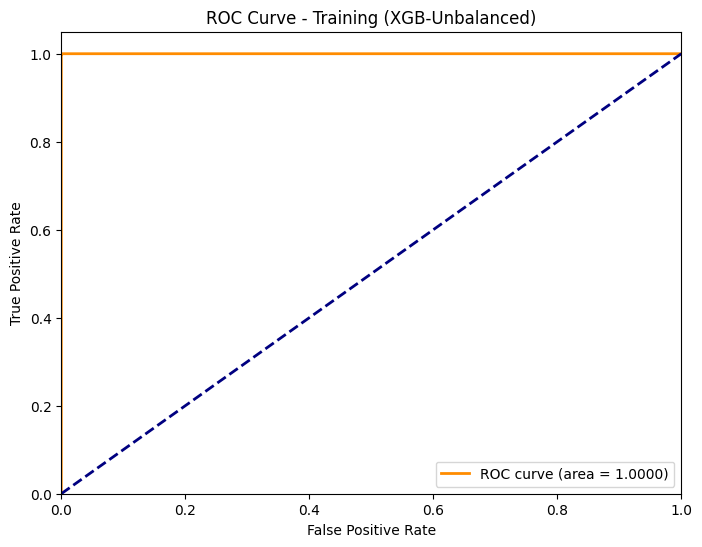


Test (XGB-Unbalanced):
Accuracy: 0.9922
Misclassification: 0.0078
AUC: 0.9922
Confusion Matrix:
[[15599    26]
 [   98   277]]


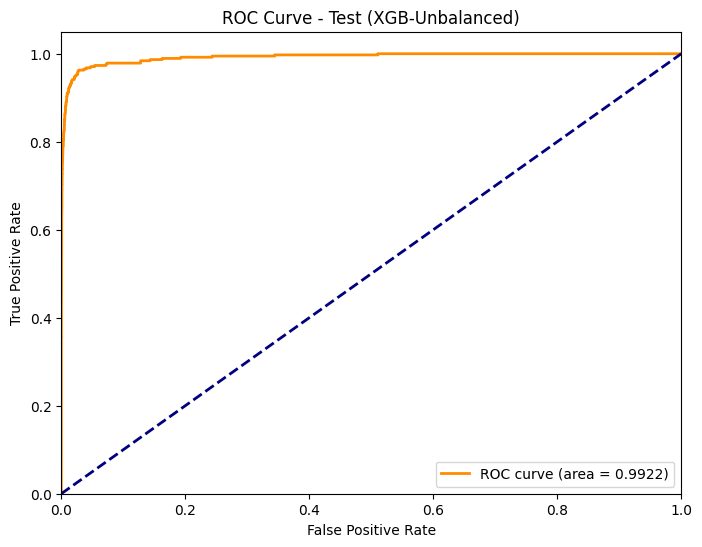


CV Error: 0.0063
Test Error: 0.0078


In [10]:
# find best alpha using CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_model = XGBClassifier(random_state=42, n_jobs=-1, objective='binary:logistic', 
                          eval_metric='logloss')

param_grid = {'reg_alpha': [0, 0.1, 0.5, 1]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=kfold, n_jobs=-1, verbose=1)

grid_search.fit(X_train_imputed, y_train)
best_alpha = grid_search.best_params_['reg_alpha']

# train with best alpha (uncompensated)
xgb_unbalanced = XGBClassifier(random_state=42, n_jobs=-1, objective='binary:logistic', 
                               eval_metric='logloss', 
                               reg_alpha=best_alpha)
xgb_unbalanced.fit(X_train_imputed, y_train)

# training metrics
y_train_pred_xgb = xgb_unbalanced.predict(X_train_imputed)
y_train_prob_xgb = xgb_unbalanced.predict_proba(X_train_imputed)[:, 1]
print_metrics(y_train, y_train_pred_xgb, y_train_prob_xgb, set_name="Training (XGB-Unbalanced)")

# test metrics
y_test_pred_xgb = xgb_unbalanced.predict(X_test_imputed)
y_test_prob_xgb = xgb_unbalanced.predict_proba(X_test_imputed)[:, 1]
print_metrics(y_test, y_test_pred_xgb, y_test_prob_xgb, set_name="Test (XGB-Unbalanced)")

# CV error
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_unbalanced, X_train_imputed, y_train, cv=kfold_cv, scoring='accuracy')
cv_error = 1 - cv_scores.mean()
test_error_xgb = 1 - accuracy_score(y_test, y_test_pred_xgb)

print(f"\nCV Error: {cv_error:.4f}")
print(f"Test Error: {test_error_xgb:.4f}")

### (f) Using SMOTE for Data Preprocessing

The **wrong way** to use SMOTE with cross-validation is to apply SMOTE to the entire training set before performing cross-validation. 

The **right way** is to use an imblearn pipeline, where in each CV fold, SMOTE is applied only to the training portion of that fold, and the validation portion remains untouched.


Training (XGB-SMOTE):
Accuracy: 1.0000
Misclassification: 0.0000
AUC: 1.0000
Confusion Matrix:
[[59000     0]
 [    1   999]]


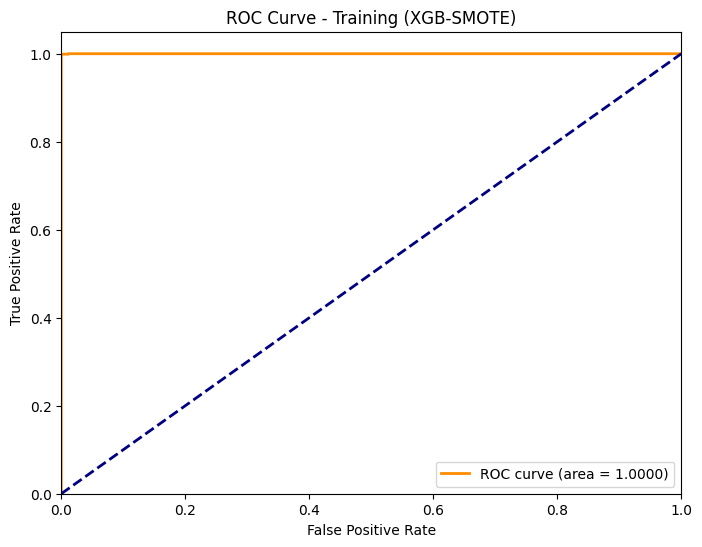


Test (XGB-SMOTE):
Accuracy: 0.9931
Misclassification: 0.0069
AUC: 0.9946
Confusion Matrix:
[[15580    45]
 [   66   309]]


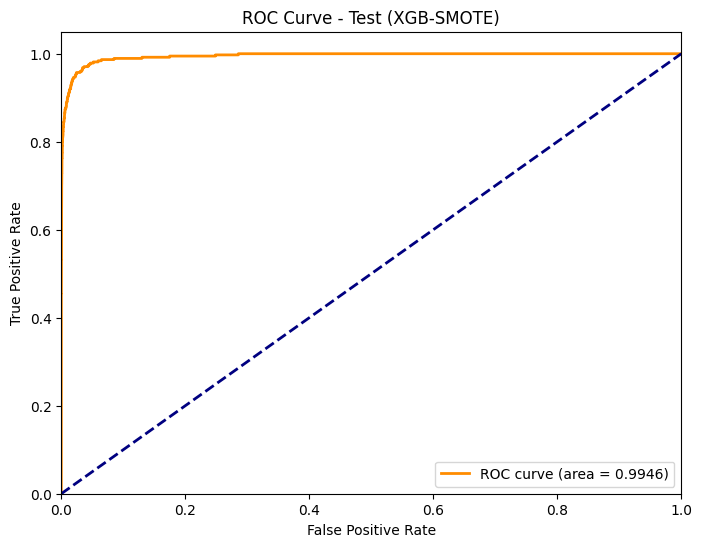


CV Error: 0.0065
Test Error: 0.0069

Comparison:
Uncompensated - Accuracy: 0.9922, Misclassification: 0.0078, AUC: 0.9922, CV: 0.0063
SMOTE         - Accuracy: 0.9931, Misclassification: 0.0069, AUC: 0.9946, CV: 0.0065


In [11]:
# XGBoost with SMOTE
xgb_smote_model = XGBClassifier(random_state=42, n_jobs=-1, objective='binary:logistic', 
                                eval_metric='logloss', 
                                reg_alpha=best_alpha)

# create pipeline
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb_smote_model)
])

smote_pipeline.fit(X_train_imputed, y_train)

# training metrics
y_train_pred_smote = smote_pipeline.predict(X_train_imputed)
y_train_prob_smote = smote_pipeline.predict_proba(X_train_imputed)[:, 1]
print_metrics(y_train, y_train_pred_smote, y_train_prob_smote, set_name="Training (XGB-SMOTE)")

# test metrics
y_test_pred_smote = smote_pipeline.predict(X_test_imputed)
y_test_prob_smote = smote_pipeline.predict_proba(X_test_imputed)[:, 1]
print_metrics(y_test, y_test_pred_smote, y_test_prob_smote, set_name="Test (XGB-SMOTE)")

# CV error (using pipeline so SMOTE is applied correctly in each fold)
kfold_smote = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_smote = cross_val_score(smote_pipeline, X_train_imputed, y_train, 
                                  cv=kfold_smote, scoring='accuracy', n_jobs=-1)

cv_error_smote = 1 - cv_scores_smote.mean()
test_error_smote = 1 - accuracy_score(y_test, y_test_pred_smote)

print(f"\nCV Error: {cv_error_smote:.4f}")
print(f"Test Error: {test_error_smote:.4f}")

# compare with uncompensated
print(f"\nComparison:")
print(f"Uncompensated - Accuracy: {accuracy_score(y_test, y_test_pred_xgb):.4f}, Misclassification: {test_error_xgb:.4f}, AUC: {roc_auc_score(y_test, y_test_prob_xgb):.4f}, CV: {cv_error:.4f}")
print(f"SMOTE         - Accuracy: {accuracy_score(y_test, y_test_pred_smote):.4f}, Misclassification: {test_error_smote:.4f}, AUC: {roc_auc_score(y_test, y_test_prob_smote):.4f}, CV: {cv_error_smote:.4f}")

**Interpretation: SMOTE vs Uncompensated XGBoost**

In this case, SMOTE slightly improves both accuracy (99.31% vs 99.22%) and AUC (0.9946 vs 0.9922), suggesting that synthetic oversampling of the minority class helps the model learn better decision boundaries. 

In the confusion matrix, the uncompensated model has 98 false negatives and 26 false positives, while SMOTE has 66 false negatives and 45 false positives. SMOTE correctly identifies significantly more positive cases (309 vs 277 true positives) while maintaining reasonable false positive rates (45 vs 26). This is a good trade-off for failure detection problems where missing a positive case is costly. 

By creating synthetic samples in the feature space between minority class examples, SMOTE helps the model learn more robust decision boundaries. The model sees more diverse examples of the positive class during training, which helps it generalize better to unseen test cases. The improvement in AUC (0.9946) indicates better separation between classes. 

However, SMOTE might hurt if the minority class is very small or has high variance, as it might create synthetic samples that don't reflect the true distribution. In cases where the classes are well-separated, SMOTE might introduce noise, and it can be computationally expensive for large datasets. 

SMOTE with XGBoost performs better than balanced class weights with Random Forest (AUC: 0.9946 vs 0.9919), suggesting that the combination of SMOTE's synthetic oversampling and XGBoost's gradient boosting is effective for this imbalanced classification problem.